In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing import Annotated

from langchain.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_search = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool(description="입력받은 파이썬 코드를 repl을 통해 실행하고 결과를 반환합니다. 에러 발생 시 에러 메시지를 반환합니다.")
def run_python_code_with_repl(code: str) -> str:
    """
    입력받은 파이썬 코드를 repl을 통해 실행하고 결과를 반환합니다.
    에러 발생 시 에러 메시지를 반환합니다.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f'Error: {repr(e)}'
    return str(result)

In [3]:
def make_system_prompt(suffix: str):
    instruction_ko = (
        "당신은 다른 어시스턴트들과 협업하는 유용한 AI 어시스턴트입니다.\n"
        "제공된 도구들을 사용하여 질문에 대한 답변을 향해 나아가세요.\n"
        "만약 당신이 완전히 답변하지 못하더라도 괜찮습니다.\n"
        "다른 도구를 가진 또 다른 어시스턴트가 당신이 멈춘 지점에서 도울 것입니다.\n"
        "진행할 수 있는 부분까지 실행하세요.\n"
        "만약 당신이나 다른 어시스턴트가 최종 답변이나 결과물을 갖고 있다면,\n"
        "응답의 맨 앞에 'FINAL ANSWER'라고 적어 팀이 멈춰야 함을 알 수 있게 하세요.\n"
        f"\n{suffix}"
)
    return instruction_ko

In [4]:
from typing import Literal

from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command


"""
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
"""

llm = ChatOpenAI(model="gpt-4.1", temperature=0)

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto


research_agent = create_react_agent(
    llm,
    tools=[tavily_search],
    prompt=make_system_prompt("You can only do research. You are working with a chart generator colleague.")
)

def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(last_message=result["messages"][-1], goto="chart_generator") # FINAL ANSWER 가 있으면 END, 없으면 chart_generator

    update={"messages": result["messages"]}
    # Command 로 흐름을 제어할 때, update는 state에서 업데이트 할 부분을 정의
    # goto는 다음 노드를 정의
    return Command(goto=goto, update=update)


chart_agent = create_react_agent(
    llm,
    tools=[run_python_code_with_repl],
    prompt=make_system_prompt("You can only do chart generation. You are working with a research colleague.")
)

def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(last_message=result["messages"][-1], goto="researcher") # FINAL ANSWER 가 있으면 END, 없으면 researcher

    update={"messages": result["messages"]}
    return Command(goto=goto, update=update)




In [5]:
from langgraph.graph import StateGraph

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")

graph = workflow.compile()



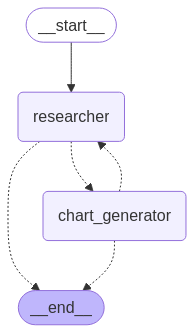

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

{'researcher': {'messages': [HumanMessage(content='지난 5년간 영국 GbP의 추세를 차트로 만들어줘, 차트를 생성하면 실행을 종료해', additional_kwargs={}, response_metadata={}, id='4236b433-1fab-427b-9f80-94d38f43da0c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jtdaDeS23vv7EU37rwP6BJTw', 'function': {'arguments': '{"query":"GBP exchange rate trend last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 272, 'total_tokens': 298, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b38e740b47', 'id': 'chatcmpl-BOvtgrz3lIpRJPDixnjzNRT6CauaG', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ede16bf5-9ad0-40c9-9c69-3504e12d322f-0', tool_calls=[{'name': 'tavily_

Python REPL can execute arbitrary code. Use with caution.
<string>:14: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
<string>:14: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
c:\Users\EST\PycharmProjects\study_langgraph\.venv\Lib\

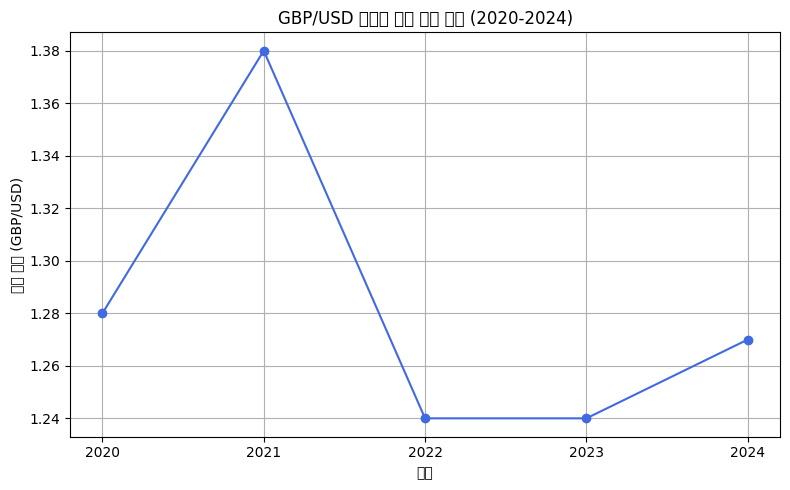

{'chart_generator': {'messages': [HumanMessage(content='지난 5년간 영국 GbP의 추세를 차트로 만들어줘, 차트를 생성하면 실행을 종료해', additional_kwargs={}, response_metadata={}, id='4236b433-1fab-427b-9f80-94d38f43da0c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jtdaDeS23vv7EU37rwP6BJTw', 'function': {'arguments': '{"query":"GBP exchange rate trend last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 272, 'total_tokens': 298, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b38e740b47', 'id': 'chatcmpl-BOvtgrz3lIpRJPDixnjzNRT6CauaG', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ede16bf5-9ad0-40c9-9c69-3504e12d322f-0', tool_calls=[{'name': 'ta

In [7]:
from langchain_core.messages import HumanMessage


input_state = {"messages": [HumanMessage(content="지난 5년간 영국 GbP의 추세를 차트로 만들어줘, 차트를 생성하면 실행을 종료해")]}

events = graph.stream(input_state, {"recursion_limit": 150})

for event in events:
    print(event)
